<a href="https://colab.research.google.com/github/pierredumontel/Churn-prediction_telecom/blob/master/Notebooks/Churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%run /content/drive/MyDrive/churn/Packages.ipynb

## Reading dataset

In [3]:
df = pd.read_csv('/content/drive/MyDrive/churn/telco_churn.csv')
df.head()

,Unnamed: 0,SeniorCitizen,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure_group_1-12,tenure_group_13-24,tenure_group_25-36,tenure_group_37-48,tenure_group_49-60,tenure_group_61-72
0,0,0,29.85,29,0,1,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
1,1,0,56.95,1889,0,0,1,1,0,1,...,0,0,0,1,0,0,1,0,0,0
2,2,0,53.85,108,1,0,1,1,0,1,...,0,0,0,1,1,0,0,0,0,0
3,3,0,42.30,1840,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,4,0,70.70,151,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0


In [ ]:
df = df.drop('Unnamed: 0', axis =1)
x = df.drop('Churn', axis =1)
x.dtypes

In [5]:
y = df['Churn']
y.value_counts()

0    5163
1    1869
Name: Churn, dtype: int64

## Train Test Split 

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)

## Decision Tree Classifier

In [15]:
model_dt = DecisionTreeClassifier(criterion = 'gini', random_state= 100, max_depth=6, min_samples_leaf=8)

In [16]:
model_dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [21]:
y_pred = model_dt.predict(x_test)
model_dt.score(x_test,y_test)
precision, recall, fscore, support = metriques(y_test, y_pred,average='weighted')
print(metrics.confusion_matrix(y_test,y_predict))
print(precision)
print(recall)

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1064
           1       0.61      0.50      0.55       343

    accuracy                           0.80      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.79      0.80      0.79      1407

[[956 108]
 [172 171]]
0.7903231497511298


In [11]:
report = classification_report(y_test, y_pred, labels=[0,1])
print(report)

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1049
           1       0.62      0.62      0.62       358

    accuracy                           0.81      1407
   macro avg       0.75      0.74      0.74      1407
weighted avg       0.81      0.81      0.81      1407



min_samples_leaf and max_depth are parameters used to prevent a tree from overfiting. Cost complexity pruning (ccp) provides another option to control the size of a tree. What why ccp will be used next. 

### Cost Complexity pruning
[This pruning technique](https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py) is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned.

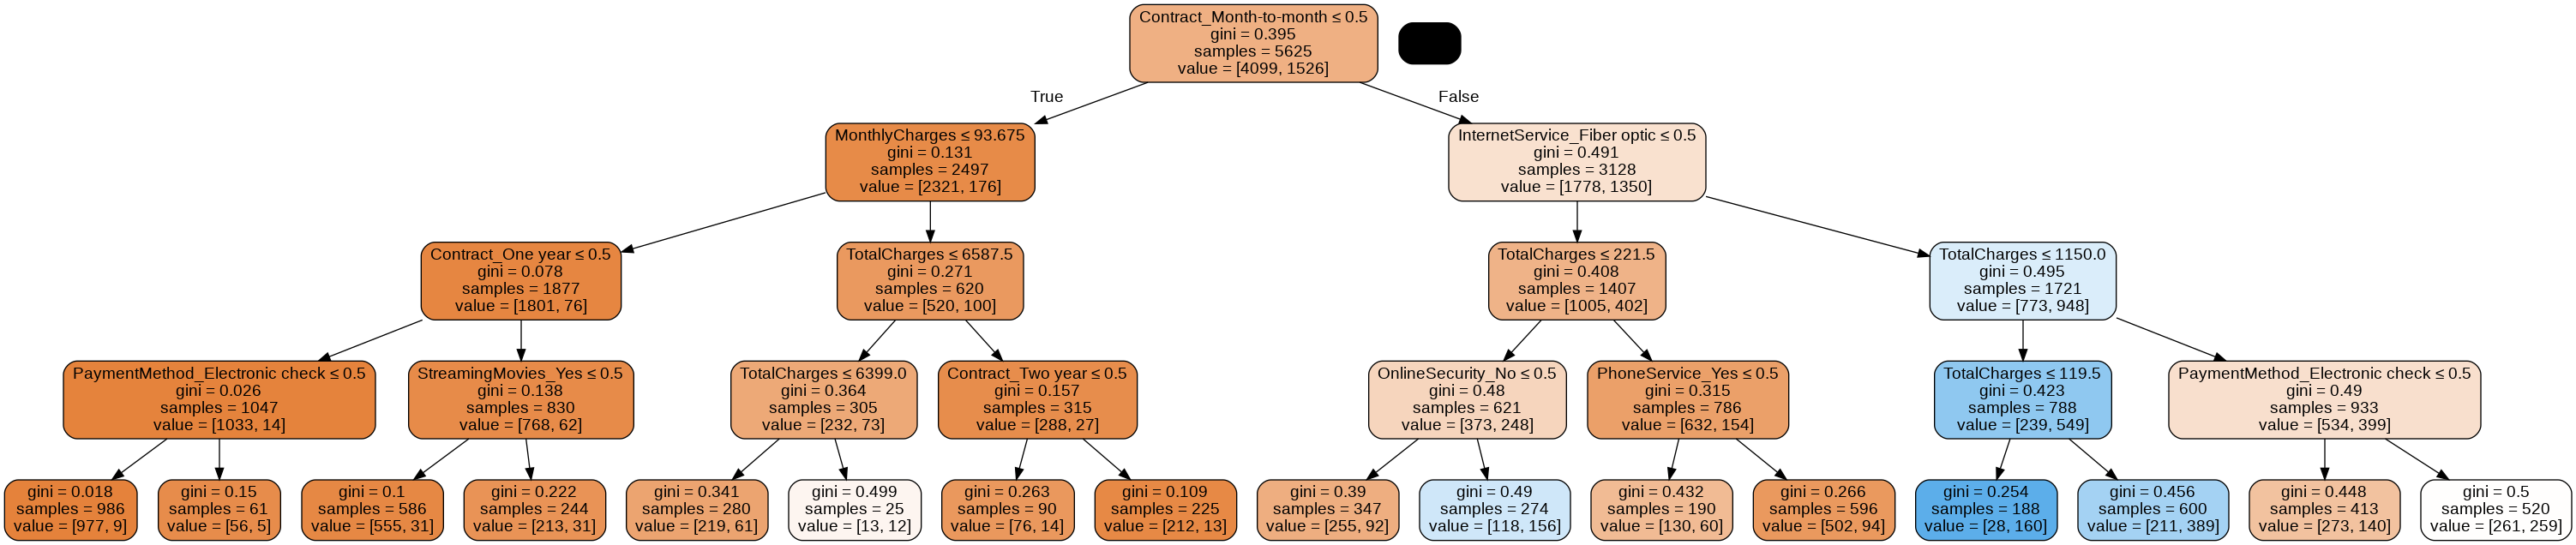

In [7]:
from six import StringIO
from IPython.display import Image
model_prune = DecisionTreeClassifier(criterion = 'gini', random_state= 100, max_depth = 4, min_samples_leaf=8)
model_prune.fit(x_train, y_train)
feature_cols = x.columns
dot_data = StringIO()
export_graphviz(model_prune, out_file = dot_data,
                filled=True,rounded=True,
                special_characters=True, feature_names=feature_cols)
from pydot import graph_from_dot_data
(graph, ) = graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [10]:
feat_importance = model_prune.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(feature_cols, model_prune.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict,orient='index')
feat_imp.rename(columns={0:'FeatureImportance'},inplace=True)
feat_imp.sort_values(by=['FeatureImportance'],ascending=False).head(12)

,FeatureImportance
Contract_Month-to-month,0.555608
TotalCharges,0.173064
InternetService_Fiber optic,0.166982
OnlineSecurity_No,0.043480
MonthlyCharges,0.020870
PaymentMethod_Electronic check,0.018814
PhoneService_Yes,0.011047
Contract_One year,0.005343
StreamingMovies_Yes,0.002906
Contract_Two year,0.001886


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

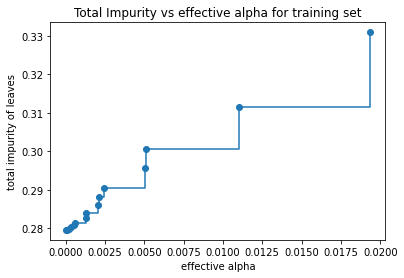

In [11]:
path = model_prune.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Minimal ccp finds the node with the "weakest link". The weakest link is characterized by an effective akpha, where the nodes with the smallest effective alpha, where the nodes with the smallest effective alpha are pruned first. to get an idea of what values of ccp_alpha could be appropriate, sklearn provides the above function that returns the effective alphas and the corresponding total leaf impurities at each step of pruning process. As alpha increases, more of the tree is pruned, which increases the total impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves. 

In [13]:
clfs = []
for ccp_alpha in ccp_alphas:
  clf = DecisionTreeClassifier(random_state= 0,
                               ccp_alpha=ccp_alpha)
  clf.fit(x_train, y_train)
  clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha : {}".format(
    clfs[-1].tree_.node_count,ccp_alphas[-1])
)

Number of nodes in the last tree is: 1 with ccp_alpha : 0.06437657132828606


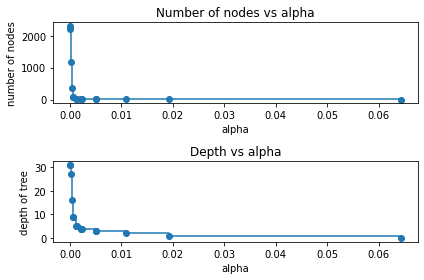

In [14]:
#clfs = clfs[:-1]
#cp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]

fig, ax = plt.subplots(2,1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

Here above we show that the number of nodes and tree depth decreases as alpha increases

In [17]:
y_preds = [clf.predict(x_test) for clf in clfs]
classification_reports = [classification_report(y_test,y_pred, labels = [0,1]) for y_pred in y_preds]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
model_dt.score(x_test,y_test)

0.806680881307747

In [19]:
print(classification_report(y_test, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87      1049
           1       0.62      0.62      0.62       358

    accuracy                           0.81      1407
   macro avg       0.75      0.74      0.74      1407
weighted avg       0.81      0.81      0.81      1407



In [20]:
y_predict = model_dt.predict(x_test)
print(metrics.confusion_matrix(y_test,y_predict))

[[914 135]
 [137 221]]


## Using an upSampling method, with SMOTEEN 

juste une note random que j'ai pas mentionné: pour les datasets super unbalanced, les modèles de boosting (xgboost, lightbgm) sont toujours les plus adaptés. Le boosting ça permet de mieux détecter des anomalies et évènement rares dans les données. Inconvénient, ça souffre pas mal du bruit (alors qu'un Random Forest sera justement bon sur des données bruités, mais va galérer sur un dataset super unbalanced)

In [21]:
sm = SMOTEENN()
X_resampled, y_resampled = sm.fit_resample(x,y)

In [22]:
xr_train, xr_test, yr_train, yr_test = train_test_split(X_resampled,y_resampled,test_size=0.2)

In [23]:
model_dt_smote = DecisionTreeClassifier(criterion = "gini", random_state=100, max_depth=6, min_samples_leaf=8)

In [24]:
model_dt_smote.fit(xr_train, yr_train)
yr_predict = model_dt_smote.predict(xr_test)
model_score_r = model_dt_smote.score(xr_test,yr_test)
print(metrics.classification_report(yr_test,yr_predict))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94       532
           1       0.94      0.96      0.95       655

    accuracy                           0.95      1187
   macro avg       0.95      0.94      0.95      1187
weighted avg       0.95      0.95      0.95      1187



In [25]:
print(metrics.confusion_matrix(yr_test,yr_predict))

[[492  40]
 [ 24 631]]


Adding Upsampling into the model, precision (quality measure) and recall (quantitative measure) are much better compared to standard model.

## Random Forest Classifier

In [26]:
model_rf = RandomForestClassifier(n_estimators=100, criterion='gini',random_state=100, max_depth=6, min_samples_leaf=8)

In [27]:
model_rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=6, min_samples_leaf=8, random_state=100)

In [28]:
y_pred=model_rf.predict(x_test)

In [29]:
print(classification_report(y_test,y_pred,labels=[0,1]))
print(metrics.confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      1.00      0.85      1049
           1       0.00      0.00      0.00       358

    accuracy                           0.75      1407
   macro avg       0.37      0.50      0.43      1407
weighted avg       0.56      0.75      0.64      1407

[[1049    0]
 [ 358    0]]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The insights give by the standard Decision tree are the same here above, precision is too low as recall is.
Let's look how upsampling could help

In [ ]:
sm = SMOTEENN()
X_resampled1, y_resampled1 = sm.fit_resample(x,y)

In [ ]:
xr_train1, xr_test1, yr_train1, yr_test1 = train_test_split(X_resampled1,y_resampled1,test_size=0.2)

In [ ]:
model_rf_smote = RandomForestClassifier(n_estimators=100, criterion='gini',random_state=100, max_depth=6, min_samples_leaf=8)

In [ ]:
model_rf_smote.fit(xr_train1,yr_train1)

In [ ]:
yr_predict1 = model_rf_smote.predict(xr_test1)
print(classification_report(yr_test1,yr_predict1,labels=[0,1]))
print(metrics.confusion_matrix(yr_test1,yr_predict1))

Using RF Classifier, we are able to match DT classifier, even roughly better looking at the precision.

## PCA

In [ ]:
pca = PCA(0.9)
xr_train_pca = pca.fit_transform(xr_train1)
xr_test_pca = pca.transform(xr_test1)
explained_variance = pca.explained_variance_ratio_

In [ ]:
model = RandomForestClassifier(n_estimators=100, criterion='gini',random_state=100, max_depth=6, min_samples_leaf=8)
model.fit(xr_train_pca,yr_train1)

In [ ]:
yr_predict_pca = model.predict(xr_test_pca)
print(classification_report(yr_test1,yr_predict_pca,labels=[0,1]))
print(metrics.confusion_matrix(yr_test1,yr_predict_pca))

## Pickling the model

In [ ]:
import pickle

In [ ]:
filename = 'model.sav'

In [ ]:
pickle.dump(model_rf_smote, open(filename,'wb'))

In [ ]:
load_model = pickle.load(open(filename,'rb'))

In [ ]:
model_score_r1 = load_model.score(xr_test1, yr_test1)
print(model_score_r1)